In [1]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 22.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import scipy.stats as stats
from scipy.stats import f_oneway, shapiro, levene
from statsmodels.stats.multitest import multipletests
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score,
                             mean_absolute_error, mean_squared_error, precision_score, recall_score, roc_auc_score,
                             r2_score)
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, cross_val_score, train_test_split)
from xgboost import XGBClassifier, XGBRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the CSV

In [4]:
data = pd.read_csv('/content/drive/My Drive/TFMSandoz/GonYari/df_Ready_For_Model_1209.csv')
#data = pd.read_csv('/content/drive/My Drive/TFM/df_Ready_For_Model_sinAgrupar.csv')
#data = pd.read_csv('/content/drive/My Drive/TFMSandoz/GonYari/df_Ready_For_Model_sinAgrupar.csv')

In [5]:
data

,family_id,Total_A,Total_B,Total_Success_Rate,num_europe,num_europe_B,patent_family_success_rate_europe,num_america,num_america_B,patent_family_success_rate_america,...,PatentFamily_Type_B,PatentFamily_Type_U,PatentFamily_Type_L,PatentFamily_Type_B6,PatentFamily_Type_A,PatentFamily_Type_C1,PatentFamily_Type_D0,PatentFamily_Type_A3,PatentFamily_Type_C,PatentFamily_Type_total
0,1.0,9,2,22.222222,0,0,0.0,3,0,0.000000,...,0,0,0,0,4,0,0,0,0,13
1,2.0,11,5,45.454545,0,0,0.0,3,1,0.333333,...,0,0,0,0,6,0,0,0,0,16
2,3.0,11,2,18.181818,0,0,0.0,4,1,0.250000,...,0,0,0,0,4,0,0,0,0,13
3,4.0,6,1,16.666667,0,0,0.0,2,0,0.000000,...,0,0,0,0,1,0,1,0,0,12
4,5.0,46,10,21.739130,0,0,0.0,17,1,0.058824,...,0,0,0,0,13,0,0,0,0,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,61.0,36,12,33.333333,0,0,0.0,10,5,0.500000,...,3,0,0,0,17,0,0,0,0,48
61,62.0,7,3,42.857143,0,0,0.0,2,2,1.000000,...,0,0,0,0,0,0,0,0,0,10
62,63.0,15,8,53.333333,0,0,0.0,2,2,1.000000,...,2,0,0,0,4,0,0,0,0,18
63,64.0,14,6,42.857143,0,0,0.0,4,4,1.000000,...,2,0,0,0,6,0,0,0,0,19


The Status columns are highly correlated to the objective variables due to the fact that they are build with this parameters.

In [6]:
columns_to_drop = data.filter(regex='^Status_').columns
df = data.drop(columns=columns_to_drop)
df

,family_id,Total_A,Total_B,Total_Success_Rate,num_europe,num_europe_B,patent_family_success_rate_europe,num_america,num_america_B,patent_family_success_rate_america,...,PatentFamily_Type_B,PatentFamily_Type_U,PatentFamily_Type_L,PatentFamily_Type_B6,PatentFamily_Type_A,PatentFamily_Type_C1,PatentFamily_Type_D0,PatentFamily_Type_A3,PatentFamily_Type_C,PatentFamily_Type_total
0,1.0,9,2,22.222222,0,0,0.0,3,0,0.000000,...,0,0,0,0,4,0,0,0,0,13
1,2.0,11,5,45.454545,0,0,0.0,3,1,0.333333,...,0,0,0,0,6,0,0,0,0,16
2,3.0,11,2,18.181818,0,0,0.0,4,1,0.250000,...,0,0,0,0,4,0,0,0,0,13
3,4.0,6,1,16.666667,0,0,0.0,2,0,0.000000,...,0,0,0,0,1,0,1,0,0,12
4,5.0,46,10,21.739130,0,0,0.0,17,1,0.058824,...,0,0,0,0,13,0,0,0,0,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,61.0,36,12,33.333333,0,0,0.0,10,5,0.500000,...,3,0,0,0,17,0,0,0,0,48
61,62.0,7,3,42.857143,0,0,0.0,2,2,1.000000,...,0,0,0,0,0,0,0,0,0,10
62,63.0,15,8,53.333333,0,0,0.0,2,2,1.000000,...,2,0,0,0,4,0,0,0,0,18
63,64.0,14,6,42.857143,0,0,0.0,4,4,1.000000,...,2,0,0,0,6,0,0,0,0,19


In [7]:
# We remove these highly correlated columns
df = df.drop(columns=['Most_Recent_Event_Application Withdrawn', 'family_id'])

**Create test and train with year => 2021**

In [8]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Train split for years =< 2021, test for > 2021
df_train = df[~df['Publication_Date_Max_year'].isin([2024, 2023, 2022,2021])]
df_test = df[df['Publication_Date_Max_year'].isin([2024, 2023, 2022,2021])]

# Separate target characteristics and variables for training
X_train = df_train.drop(columns=['percentage_revoked', 'totally_revoked', 'Publication_Date_Max_year'])
y_train_reg = df_train['percentage_revoked']
y_train_clf = df_train['totally_revoked']

# Separate target characteristics and variables for testing
X_test = df_test.drop(columns=['percentage_revoked', 'totally_revoked', 'Publication_Date_Max_year'])
y_test_reg = df_test['percentage_revoked']
y_test_clf = df_test['totally_revoked']

# **First model for the Classification variable**

In [9]:
# RandomForest model for classification
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train_clf)
y_pred_clf_rf = rf_clf.predict(X_test)

# Assessment
print("Evaluación para la variable binaria (RandomForest):")
print(classification_report(y_test_clf, y_pred_clf_rf))

Evaluación para la variable binaria (RandomForest):
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       0.00      0.00      0.00         3

    accuracy                           0.81        16
   macro avg       0.41      0.50      0.45        16
weighted avg       0.66      0.81      0.73        16



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Calculate de AUC and Accuracy for Decesion Tree Classifier

In [10]:
# Calculate predictions
feature_names = X_train.columns.tolist()
df_train.loc[:, 'yhat_proba'] = rf_clf.predict_proba(df_train[feature_names])[:, 1]
df_test.loc[:, 'yhat_proba'] = rf_clf.predict_proba(df_test[feature_names])[:, 1]

# Calculate AUC
print(f"AUC Train: {roc_auc_score(y_train_clf, df_train['yhat_proba'])}")
print(f"AUC Test: {roc_auc_score(y_test_clf, df_test['yhat_proba'])}")

# Calculate Accuracy
print(f"Accuracy Train: {accuracy_score(y_train_clf, df_train['yhat_proba'] > 0.5)}")
print(f"Accuracy Test: {accuracy_score(y_test_clf, df_test['yhat_proba'] > 0.5)}")

AUC Train: 1.0
AUC Test: 0.6666666666666666
Accuracy Train: 1.0
Accuracy Test: 0.8125


<ipython-input-10-e5d665b3263c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'yhat_proba'] = rf_clf.predict_proba(df_train[feature_names])[:, 1]
<ipython-input-10-e5d665b3263c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'yhat_proba'] = rf_clf.predict_proba(df_test[feature_names])[:, 1]


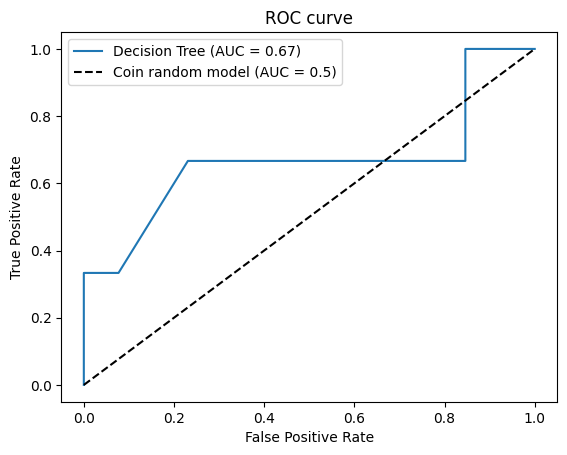

In [11]:
# Calculate ROC curve
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test_clf, df_test.yhat_proba)

roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc,
    estimator_name='Decision Tree'
)
display.plot()

plt.title("ROC curve")
plt.plot([0, 1], [0, 1], "k--", label="Coin random model (AUC = 0.5)")
plt.legend()

Confusion matrix for Decision Tree for Classification

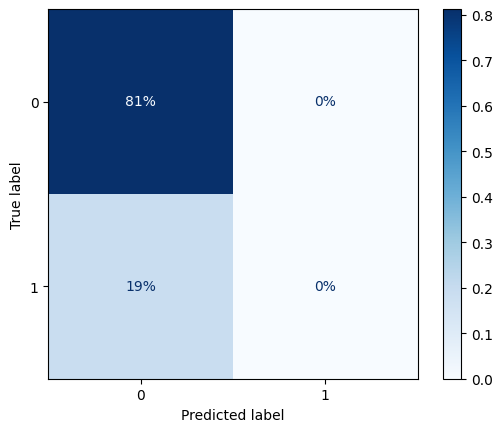

[[0.8125 0.    ]
 [0.1875 0.    ]]


In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    estimator=rf_clf,
    X=df_test[feature_names],
    y=y_test_clf,
    cmap=plt.cm.Blues,
    normalize='all',
    values_format='.0%'
)
plt.show()

# Create the confusion matrix
cm = confusion_matrix(y_test_clf, df_test['yhat_proba'] >= 0.5, normalize='all')
print(cm)


After looking at the confusion matrix and the ROC curve we see that the randomForest model is very simplistic. Since it is assigning 0 to all predictions.

With only 65 rows, the model may struggle to generalize, even if it is robust against overfitting. Random Forest may require a significant amount of data to achieve optimal performance.

# **First model for Regression variable**



In [13]:
# Continuous target variable
y_continua = df['percentage_revoked']

# RandomForest model for regression
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train_reg)
y_pred_reg_rf = rf_reg.predict(X_test)

Calculate the MAE and el MSE for Decision Tree for Regression

In [14]:
# Predictions for regression
df_train.loc[:, 'yhat_reg'] = rf_reg.predict(X_train)
df_test.loc[:, 'yhat_reg'] = rf_reg.predict(X_test)

# Calculate MSE and MAE for regression
mse_train = mean_squared_error(y_train_reg, df_train['yhat_reg'])
mse_test = mean_squared_error(y_test_reg, df_test['yhat_reg'])
mae_train = mean_absolute_error(y_train_reg, df_train['yhat_reg'])
mae_test = mean_absolute_error(y_test_reg, df_test['yhat_reg'])

print(f"MSE Train: {mse_train}")
print(f"MSE Test: {mse_test}")
print(f"MAE Train: {mae_train}")
print(f"MAE Test: {mae_test}")

MSE Train: 0.01102857142857143
MSE Test: 0.08787170138888889
MAE Train: 0.08
MAE Test: 0.24489583333333337


<ipython-input-14-957b1d16f423>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'yhat_reg'] = rf_reg.predict(X_train)
<ipython-input-14-957b1d16f423>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'yhat_reg'] = rf_reg.predict(X_test)


<ipython-input-15-ffdc4a9f9508>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_train_reg.min(), y_train_reg.max()], [y_train_reg.min(), y_train_reg.max()], 'k--', lw=2, color='black')
<ipython-input-15-ffdc4a9f9508>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2, color='black')


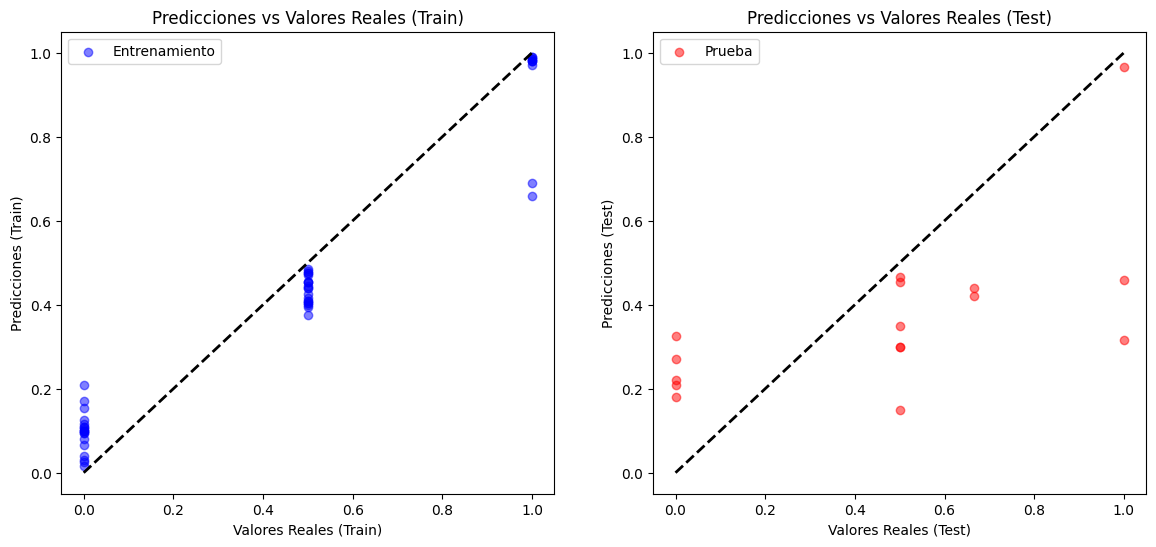

In [15]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values ​​for training and testing
plt.figure(figsize=(14, 6))

# For training
plt.subplot(1, 2, 1)
plt.scatter(y_train_reg, rf_reg.predict(X_train), alpha=0.5, color='blue', label='Entrenamiento')
plt.plot([y_train_reg.min(), y_train_reg.max()], [y_train_reg.min(), y_train_reg.max()], 'k--', lw=2, color='black')
plt.xlabel('Valores Reales (Train)')
plt.ylabel('Predicciones (Train)')
plt.title('Predicciones vs Valores Reales (Train)')
plt.legend()

# For test
plt.subplot(1, 2, 2)
plt.scatter(y_test_reg, rf_reg.predict(X_test), alpha=0.5, color='red', label='Prueba')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2, color='black')
plt.xlabel('Valores Reales (Test)')
plt.ylabel('Predicciones (Test)')
plt.title('Predicciones vs Valores Reales (Test)')
plt.legend()

plt.show()


This behavior indicates several potential issues:
Overfitting: The model has overfitted the training data, resulting in poor performance on new data (test set).


Lack of generalization: The model is not adequately capturing the underlying relationship between the features and the target variable.


Discretization of predictions: On the training set, the model is simplifying its predictions to three principal values, which does not translate well to the test set.

## **Second Approach**

In [16]:
#  Create RandomForest model for regression and classification
rf_reg = RandomForestRegressor(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)

# Hyperparameters
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_reg = GridSearchCV(
    estimator=rf_reg,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    verbose=3
)


grid_search_clf = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='roc_auc',
    verbose=3
)


grid_search_reg.fit(X_train, y_train_reg)
grid_search_clf.fit(X_train, y_train_clf)

print("Mejores hiperparámetros encontrados:")
print(grid_search_reg.best_params_)
print(grid_search_clf.best_params_)

print("Mejor puntuación:")
print(grid_search_reg.best_score_)
print(grid_search_clf.best_score_)

best_rf_reg = grid_search_reg.best_estimator_
best_rf_clf = grid_search_clf.best_estimator_

y_pred_best_rf_clf= best_rf_clf.predict(X_test)
y_pred_best_rf_reg= best_rf_reg.predict(X_test)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Mejores hiperparámetros encontrados:
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Mejor puntuación:
-0.25220588235294117
0.8846153846153846


Calculate de AUC and Accuracy for Decesion Tree Classifier

In [17]:
# Calculate predictions
feature_names = X_train.columns.tolist()
df_train.loc[:, 'yhat_proba'] = best_rf_clf.predict_proba(df_train[feature_names])[:, 1]
df_test.loc[:, 'yhat_proba'] = best_rf_clf.predict_proba(df_test[feature_names])[:, 1]

# Calculate AUC
print(f"AUC Train: {roc_auc_score(y_train_clf, df_train['yhat_proba'])}")
print(f"AUC Test: {roc_auc_score(y_test_clf, df_test['yhat_proba'])}")

# Calculate Accuracy
print(f"Accuracy Train: {accuracy_score(y_train_clf, df_train['yhat_proba'] > 0.5)}")
print(f"Accuracy Test: {accuracy_score(y_test_clf, df_test['yhat_proba'] > 0.5)}")

AUC Train: 1.0
AUC Test: 0.47435897435897434
Accuracy Train: 0.9795918367346939
Accuracy Test: 0.875


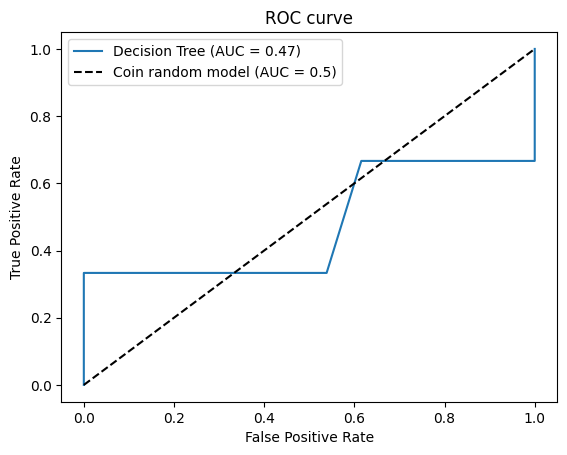

In [18]:
# Calculate ROC Curve
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test_clf, df_test.yhat_proba)

roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc,
    estimator_name='Decision Tree'
)
display.plot()

plt.title("ROC curve")
plt.plot([0, 1], [0, 1], "k--", label="Coin random model (AUC = 0.5)")
plt.legend()

Confusion matrix for Decision Tree for Classification

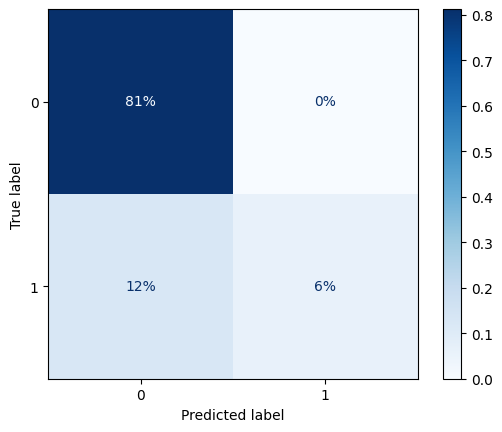

[[0.8125 0.    ]
 [0.125  0.0625]]


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    estimator=best_rf_clf,
    X=df_test[feature_names],
    y=y_test_clf,
    cmap=plt.cm.Blues,
    normalize='all',
    values_format='.0%'
)
plt.show()

# Create the confusion matrix
cm = confusion_matrix(y_test_clf, df_test['yhat_proba'] >= 0.5, normalize='all')
print(cm)


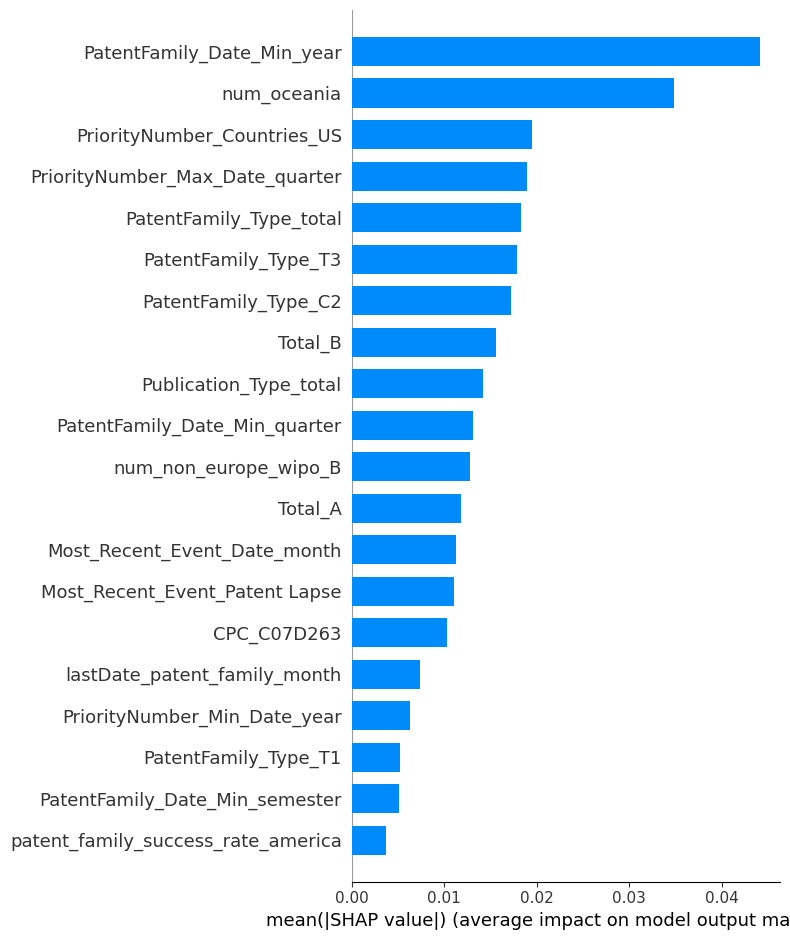

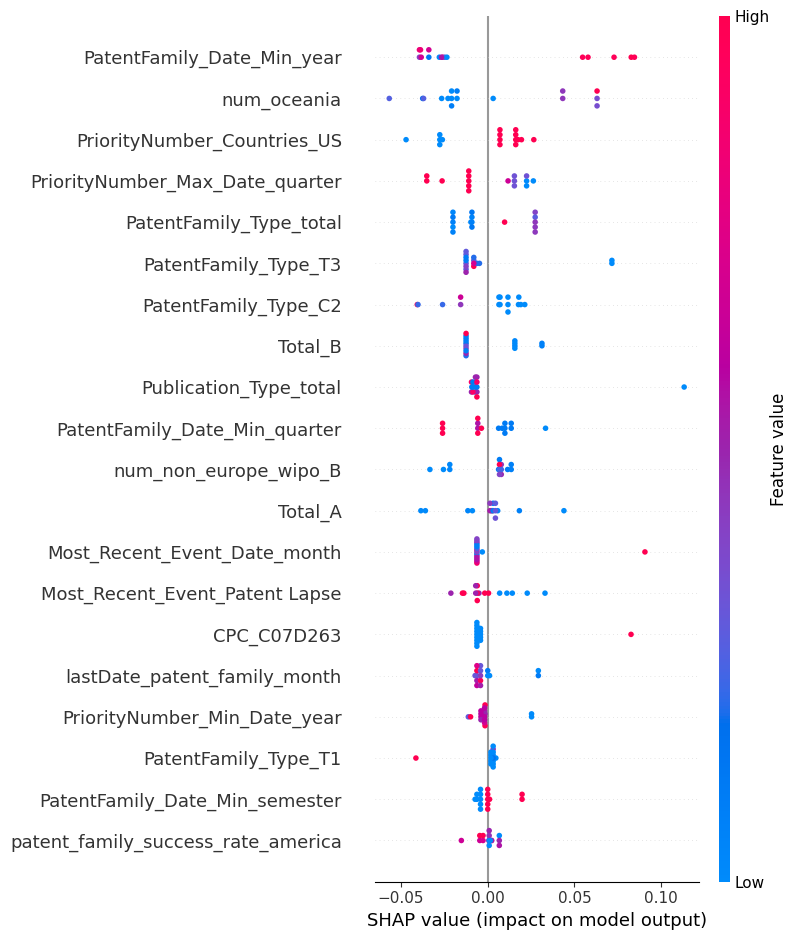

In [20]:
# Create a SHAP explainer for the model
explainer_lr = shap.Explainer(best_rf_clf, X_test)

# Calculate SHAP values ​​for the test set
shap_values_lr = explainer_lr(X_test)

# Get the feature names
feature_names = X_test.columns.tolist()

# Summary of SHAP values
shap.summary_plot(shap_values_lr[:,:,1], X_test, feature_names=feature_names, plot_type="bar")
plt.show()

# If you prefer a scatter plot instead of bars:
shap.summary_plot(shap_values_lr[:,:,1], X_test, feature_names=feature_names)
plt.show()

Calculate the MAE and el MSE for Decision Tree for Regression

In [21]:
# Predictions for regression
df_train.loc[:, 'yhat_reg'] = best_rf_reg.predict(X_train)
df_test.loc[:, 'yhat_reg'] = best_rf_reg.predict(X_test)

# Calculate MSE and MAE for regression
mse_train = mean_squared_error(y_train_reg, df_train['yhat_reg'])
mse_test = mean_squared_error(y_test_reg, df_test['yhat_reg'])
mae_train = mean_absolute_error(y_train_reg, df_train['yhat_reg'])
mae_test = mean_absolute_error(y_test_reg, df_test['yhat_reg'])

print(f"MSE Train: {mse_train}")
print(f"MSE Test: {mse_test}")
print(f"MAE Train: {mae_train}")
print(f"MAE Test: {mae_test}")

MSE Train: 0.016071428571428573
MSE Test: 0.1001388888888889
MAE Train: 0.09489795918367348
MAE Test: 0.26458333333333334


<ipython-input-22-aa224f2c9f9e>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_train_reg.min(), y_train_reg.max()], [y_train_reg.min(), y_train_reg.max()], 'k--', lw=2, color='black')
<ipython-input-22-aa224f2c9f9e>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2, color='black')


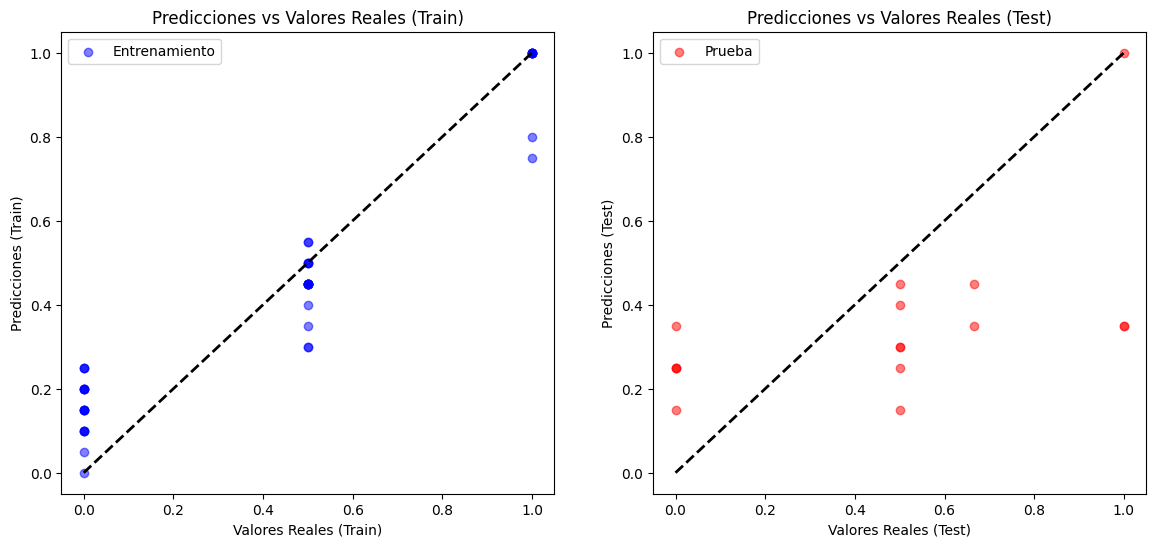

In [22]:
import matplotlib.pyplot as plt

# Graficar predicciones vs valores reales para entrenamiento y prueba
plt.figure(figsize=(14, 6))

# Para entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(y_train_reg, best_rf_reg.predict(X_train), alpha=0.5, color='blue', label='Entrenamiento')
plt.plot([y_train_reg.min(), y_train_reg.max()], [y_train_reg.min(), y_train_reg.max()], 'k--', lw=2, color='black')
plt.xlabel('Valores Reales (Train)')
plt.ylabel('Predicciones (Train)')
plt.title('Predicciones vs Valores Reales (Train)')
plt.legend()

# Para prueba
plt.subplot(1, 2, 2)
plt.scatter(y_test_reg, best_rf_reg.predict(X_test), alpha=0.5, color='red', label='Prueba')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2, color='black')
plt.xlabel('Valores Reales (Test)')
plt.ylabel('Predicciones (Test)')
plt.title('Predicciones vs Valores Reales (Test)')
plt.legend()

plt.show()


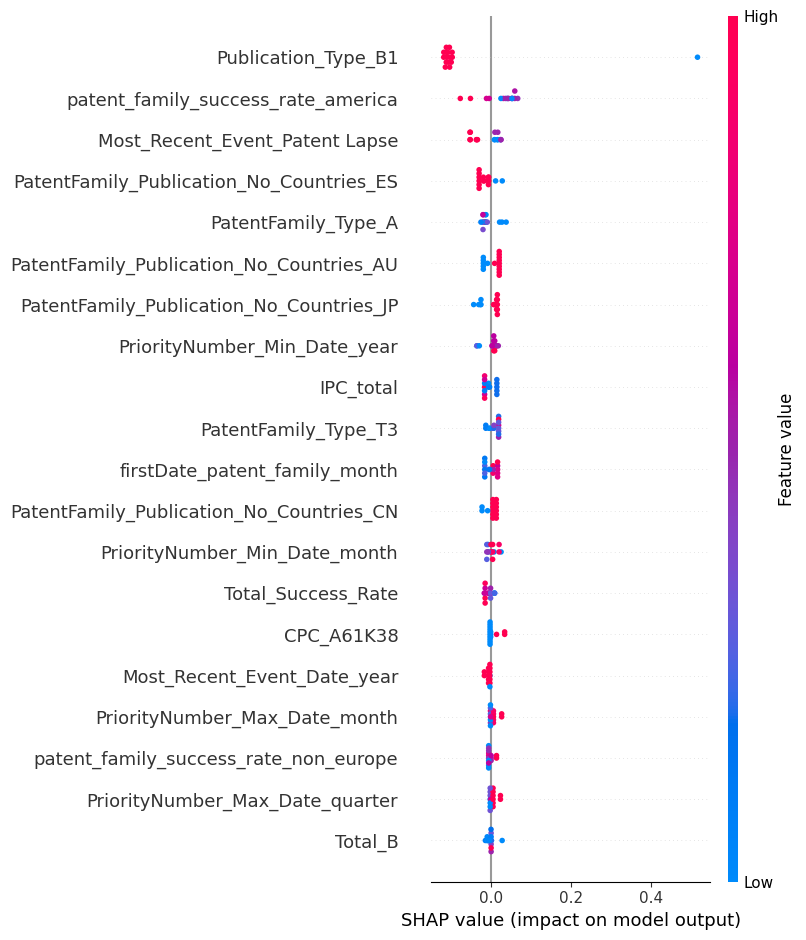

In [23]:
# Create an explainer
explainer_reg = shap.Explainer(best_rf_reg, X_train)

# Calculate SHAP values
shap_values_reg = explainer_reg(X_test)

# Summary diagram
shap.summary_plot(shap_values_reg, X_test)


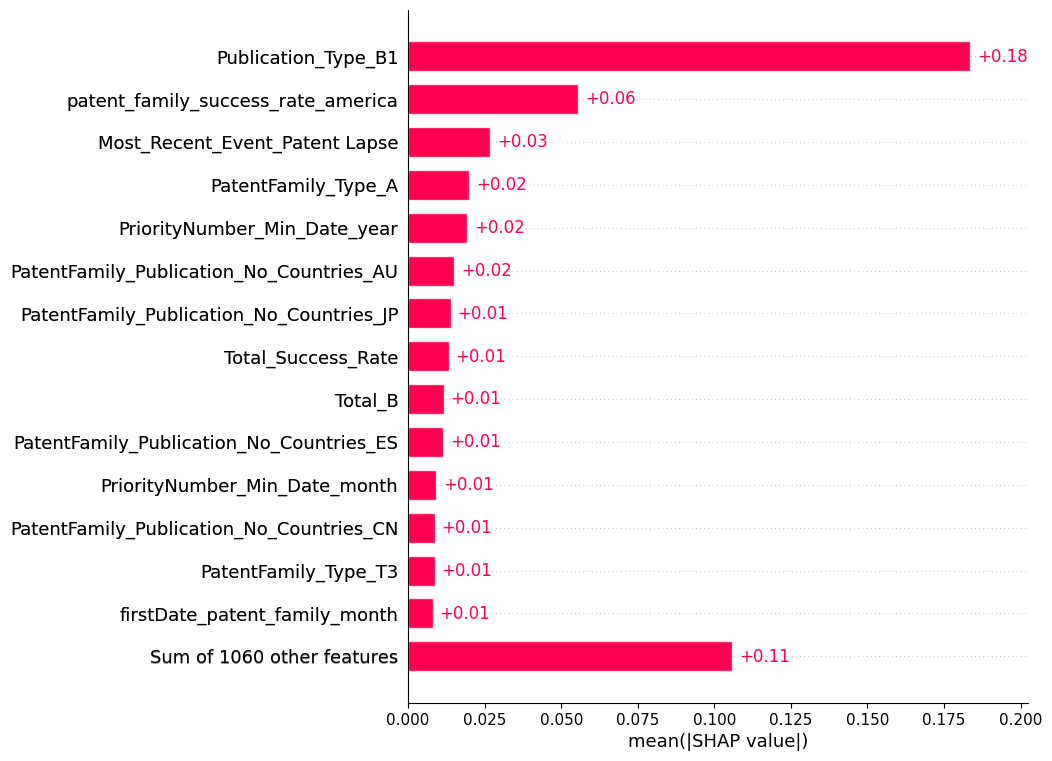

In [24]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(best_rf_reg)
shap_values = explainer(X_train)
shap.plots.bar(shap_values, max_display=15)

Weights and equations of the models

In [25]:
# Get the importance of the variables
importances = best_rf_clf.feature_importances_

# Order the importances and obtain the indexes of the 5 most significant
indices = np.argsort(importances)[::-1]

# Print the names of the 5 most significant variables
for i in range(5):
    print(f"Variable {feature_names[indices[i]]}: {importances[indices[i]]}")

Variable PriorityNumber_Countries_US: 0.0692807025912488
Variable PatentFamily_Date_Min_year: 0.046143065482448474
Variable Publication_Type_total: 0.04469264427438996
Variable Representative_DERKS WILBERT ET AL: 0.040165615270625676
Variable Total_A: 0.036474912264666724


In [26]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Get the importance of the variables
importances = best_rf_reg.feature_importances_

# Order the importances and obtain the indexes of the 5 most significant
indices = np.argsort(importances)[::-1]

# Print the names of the 5 most significant variables
for i in range(5):
    print(f"Variable {feature_names[indices[i]]}: {importances[indices[i]]}")


Variable Publication_Type_B1: 0.4544010950939377
Variable patent_family_success_rate_america: 0.07329695047616966
Variable PriorityNumber_Min_Date_year: 0.04429433063904876
Variable Most_Recent_Event_Patent Lapse: 0.03733539614673965
Variable PatentFamily_Type_A: 0.028683893977854435
